# Worksheet

[FORM](https://forms.gle/fNezueqNgwqLu3iM8)

## Linear Model Evaluation

Notice that R^2 only increases with the number of explanatory variables used. Hence the need for an adjusted R^2 that penalizes for insignificant explanatory variables.

In [15]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

SAMPLE_SIZE = 100
beta = [1, 5]
X = -10.0 + 10.0 * np.random.random(SAMPLE_SIZE)
Y = beta[0] + beta[1] * X + np.random.randn(SAMPLE_SIZE)

for i in range(1, 15):
    X_transform = PolynomialFeatures(degree=i, include_bias=False).fit_transform(X.reshape(-1, 1))
    model = LinearRegression()
    model.fit(X_transform, Y)
    print(model.score(X_transform, Y))

0.9945826144313966
0.9946201809257829
0.9946471053101211
0.9946534432777431
0.9947059949520863
0.9947074461704298
0.994707608121796
0.9947869895110119
0.9948198887898864
0.9951848444886159
0.9951965442390005
0.9953882627854057
0.995395848219324
0.995277795907357


## Simulate and Count

What is the probability that a fair coin generated this sequence of coin tosses.

Dataset of coin tosses:  [0, 1, 1, 1, 1, 0]
Probability that a fair coin generates it:  0.234375

We simulated a fair coin being flipped 6 times.
In our 1000 simulations, this was the count of the number of Heads (out of 6) we observed: 


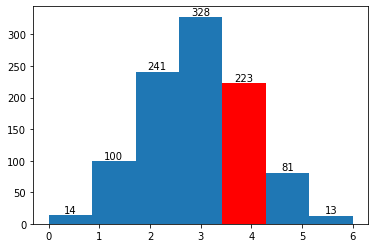

In [16]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

def num_successes(flips):
    return sum(flips)

SAMPLE_SIZE = 6
og_flips = [np.random.choice([0, 1]) for _ in range(SAMPLE_SIZE)]
print("Dataset of coin tosses: ", og_flips)
print("Probability that a fair coin generates it: ", binom.pmf(num_successes(og_flips), SAMPLE_SIZE, 1/2))
print()

p_est = []
NUM_SIMULATIONS = 1000

print("We simulated a fair coin being flipped "
      + str(SAMPLE_SIZE)
      + " times.\nIn our "
      + str(NUM_SIMULATIONS)
      + " simulations, this was the count of the number of Heads (out of 6) we observed: "
    )

for _ in range(NUM_SIMULATIONS):
    flips = [np.random.choice([0, 1]) for _ in range(SAMPLE_SIZE)]
    p_est.append(num_successes(flips))

fig, ax = plt.subplots()
_, bins, patches = ax.hist(p_est, bins=SAMPLE_SIZE + 1)
p = np.digitize([num_successes(og_flips)], bins)
patches[p[0]-1].set_facecolor('r')
ax.bar_label(patches)
plt.show()


In Linear Regression, our most pressing question is whether there is in fact a true relationship between our predictors `X` and our target `y` - or if the relationship we observed was just a fluke.

Through simulations and counting, let's see just how likely or unlikely it is to observe linear relationships in data that was generated by an `X` and `y` that are not linearly related.

True beta =  [0 0]
Observed beta =  [ 0.12740217 -0.07422367]


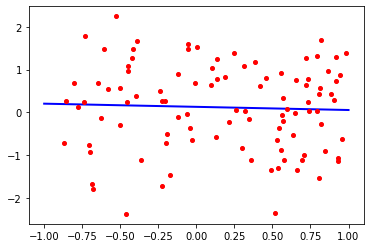

In [5]:
import numpy as np
import matplotlib.pyplot as plt

SAMPLE_SIZE = 100

xlin = -1.0 + 2.0 * np.random.random(SAMPLE_SIZE)
y = 0.0 * xlin + np.random.randn(SAMPLE_SIZE) # beta = 0 means there is no relationship between x and y.

intercept = np.ones(np.shape(xlin)[0])
X = np.array([intercept, xlin]).T
beta = np.linalg.inv(X.T @ X) @ X.T @ y

print("True beta = ", np.array([0, 0]))
print("Observed beta = ", beta)

xplot = np.linspace(-1,1,20)
yestplot = beta[0] + beta[1] * xplot
plt.plot(xplot, yestplot,'b-',lw=2)
plt.plot(xlin, y,'ro',markersize=4)
plt.show()

Lets see what happens if we repeat this 1000 times and record the estimated intercept and slope each time to plot them in a histogram.

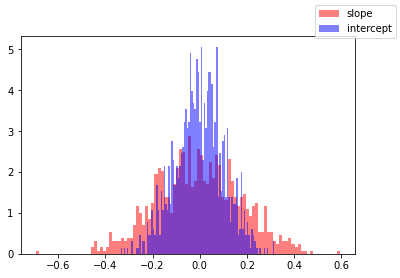

In [6]:
NUM_TRIALS = 1000
inter = []
slope = []
for _ in range(NUM_TRIALS):

    xlin = -1.0 + 2.0 * np.random.random(SAMPLE_SIZE)
    y = 0.0 * xlin + np.random.randn(SAMPLE_SIZE)

    intercept = np.ones(np.shape(xlin)[0])
    X = np.array([intercept, xlin]).T
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    inter.append(beta[0])
    slope.append(beta[1])

fig, ax = plt.subplots()
ax.hist(slope, bins=100, density=True, color='r', alpha=.5, label="slope")
ax.hist(inter, bins=100, density=True, color='b', alpha=.5, label="intercept")
fig.legend()
plt.show()

If we then encountered a dataset of size 100 as above and the slope was say 2, we would have a lot of evidence / reasonable grounds to say that most likely this dataset was NOT generated with a true slope of 0.

Running these simulations can be expensive sometimes so computing these probabilities directly (instead of through simulations) would be nice. What we want to know is: given a true beta, what is the probability of observing a range of estimated betas on a dataset of a specific size N.

Lets take this one step at a time.

## Computing Probabilities

We know that:

$$\hat\beta-\beta \sim \mathcal{N}(0,\sigma^2 (X^TX)^{-1})$$

thus for each component $k$ of $\hat\beta$ (here there are only two - one slope and one intercept)

$$\hat\beta_k -\beta_k \sim \mathcal{N}(0, \sigma^2 S_{kk})$$

where $S_{kk}$ is the $k^\text{th}$ diagonal element of $(X^TX)^{-1}$. Thus, we know that 

$$z_k = \frac{\hat\beta_k -\beta_k}{\sqrt{\sigma^2 S_{kk}}} \sim \mathcal{N}(0,1)$$

Verify that this is the case through a simulation and compare it to the standard normal pdf by plotting it on top of the histogram.

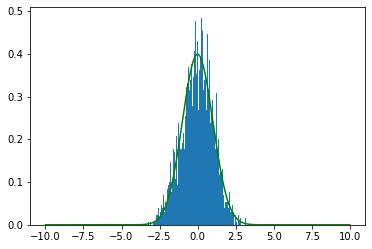

In [13]:
from scipy.stats import norm

true_beta = np.array([1, 5])  # true intercept and slope
sigma = 1  # standard deviation of noise
beta_hist = []
for _ in range(1000):
    # Generate random X values and corresponding Y values with noise
    X = -10.0 + 10.0 * np.random.random(SAMPLE_SIZE)
    Y = true_beta[0] + true_beta[1] * X + np.random.normal(scale=sigma, size=SAMPLE_SIZE)
    
    # Add intercept term to X for linear regression
    X_design = np.vstack([np.ones(SAMPLE_SIZE), X]).T
    
    # Fit the linear regression model to obtain beta estimates
    model = LinearRegression(fit_intercept=False)
    model.fit(X_design, Y)
    beta_hat = model.coef_
    
    # Compute (X^T X)^-1 for standard errors
    XtX_inv = np.linalg.inv(X_design.T @ X_design)
    standard_errors = np.sqrt(np.diag(sigma**2 * XtX_inv))
    
    # Compute the standardized differences (z-scores)
    beta_diff = (beta_hat - true_beta) / standard_errors
    beta_hist.extend(beta_diff)  # add both intercept and slope differences to the histogram data

xs = np.linspace(-10,10,1000)
fig, ax = plt.subplots()
ax.hist(beta_hist, bins=100, density=True)
ax.plot(xs, norm.pdf(xs, 0, 1), color='green')
plt.show()

#### FORM Q1

Use the CDF of a standard normal distribution, to provide the probability that the following dataset's true slope is greater than 0. Assume that $\sigma^2 = 1$

0.534308168985353


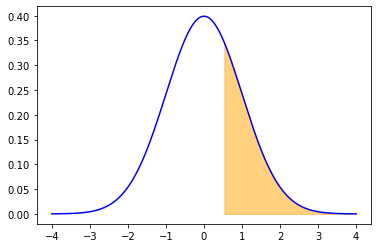

In [12]:
from scipy.stats import norm

x = np.array([-0.1920605, -0.11290798, -0.56434374, -0.67052057, -0.19233284, -0.42403586, -0.8114285, -0.38986946, -0.37384161, -0.50930229])
y = np.array([-0.34063108, -0.33409286, 0.34245857, 0.11062295, 0.76682389, 0.86592388, -1.68912015, -2.01463592, 1.61798563, 0.60557414])

intercept = np.ones(np.shape(x)[0])
X = np.array([intercept, x]).T
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

z = beta_hat[1]/((X.T @ X)[1][1])
print(z)

x = np.linspace(-4, 4, 1000)
pdf = norm.pdf(x, loc=0, scale=1)

fig, ax = plt.subplots()
ax.plot(x, pdf, color="blue")
x_fill = np.linspace(z, 4, 1000)
pdf_fill = norm.pdf(x_fill, loc=0, scale=1)
ax.fill_between(x_fill, pdf_fill, color="orange", alpha=0.5, label=f"Area to the right of {z}")
plt.show()

In practice we don't know the standard deviation and need to use an unbiased estimate of the standard deviation instead. This estimate is the standard error `s`

$$s = \sqrt{\frac{RSS}{n - p}}$$

where p is the number of parameters beta (here there are 2 - one slope and one intercept). This normalized $\hat\beta$ can be shown to follow a t-distribution with `n-p` degrees of freedom. Verify this is the case with a simulation.

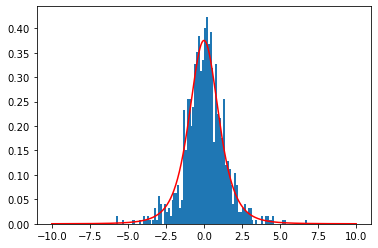

In [18]:
from scipy.stats import t

def standard_error(ytrue, ypred, X):
    RSS = np.sum((ytrue - ypred) ** 2)
    return np.sqrt(RSS / (len(ytrue) - X.shape[1]))

beta_hist = []
for _ in range(1000):
    # Generate random data
    x = -10 + 20 * np.random.random(SAMPLE_SIZE)
    y = true_beta[0] + true_beta[1] * x + np.random.normal(scale=1, size=SAMPLE_SIZE)
    
    # Add intercept term
    X = np.vstack([np.ones(SAMPLE_SIZE), x]).T
    
    # Estimate beta using least squares
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
    # Predictions and standard error calculation
    y_pred = X @ beta_hat
    s = standard_error(y, y_pred, X)
    
    # Calculate the normalized beta_hat for the slope component
    slope_se = s * np.sqrt(np.linalg.inv(X.T @ X)[1, 1])
    t_value = (beta_hat[1] - true_beta[1]) / slope_se
    beta_hist.append(t_value)

xs = np.linspace(-10,10,1000)
fig, ax = plt.subplots()
ax.hist(beta_hist, bins=100, density=True)
ax.plot(xs, t.pdf(xs, SAMPLE_SIZE - 2), color='red')
plt.show()

#### FORM Q2

Use a t distribution to provide the probability that the following dataset's true slope is greater than 0

In [19]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([-0.1920605, -0.11290798, -0.56434374, -0.67052057, -0.19233284, -0.42403586, -0.8114285, -0.38986946, -0.37384161, -0.50930229])
y = np.array([-0.34063108, -0.33409286, 0.34245857, 0.11062295, 0.76682389, 0.86592388, -1.68912015, -2.01463592, 1.61798563, 0.60557414])

# Adding intercept to X
X = np.vstack([np.ones(len(x)), x]).T

# Estimate beta (slope and intercept) using least squares
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
slope_estimate = beta_hat[1]

# Calculate residuals and standard error of the slope
y_pred = X @ beta_hat
residuals = y - y_pred
RSS = np.sum(residuals ** 2)
s_squared = RSS / (len(y) - X.shape[1])  # Mean square error
slope_se = np.sqrt(s_squared * np.linalg.inv(X.T @ X)[1, 1])

# Compute t-statistic for the slope
t_stat = slope_estimate / slope_se

# Degrees of freedom
df = len(y) - 2

# Calculate the one-sided p-value (right tail)
p_value = 1 - t.cdf(t_stat, df)

print("Slope Estimate:", slope_estimate)
print("Standard Error of Slope:", slope_se)
print("t-Statistic:", t_stat)
print("p-value (Probability true slope > 0):", p_value)

Slope Estimate: 1.1990282719906205
Standard Error of Slope: 1.7523026381576574
t-Statistic: 0.6842586696389725
p-value (Probability true slope > 0): 0.2565710360452875
